In [1]:
%load_ext autoreload
%autoreload 2

### plotting setup

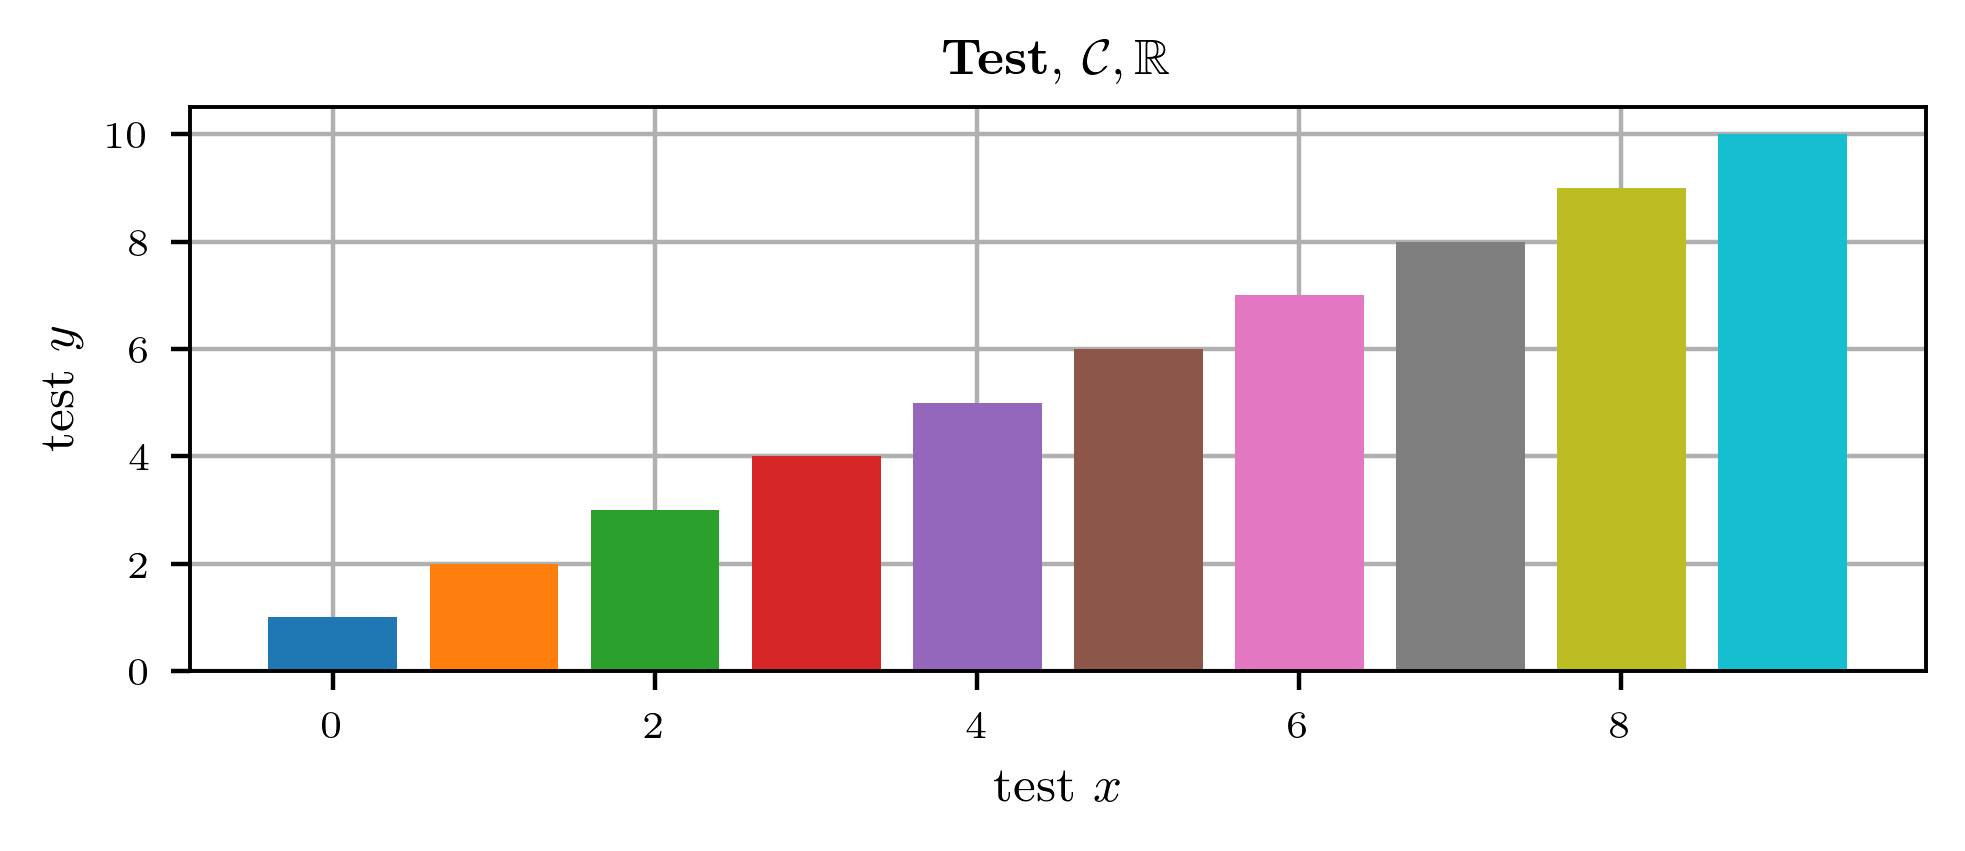

In [2]:
import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.60107  # in  --> Confirmed with template explanation

fs_m1 = 7  # for figure ticks
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})

# Test setup

plt.figure(dpi=400, figsize=(text_width, text_width/3))
plt.grid(0.3, zorder=0)
for i in range(10):
    plt.bar(i, i + 1, color=f'C{i}', zorder=2)
    # ^ This zorder nonsense makes the grid  lines go behid the bars. I don't know why this is needed for barplots, but shouldn't usually be needed.
plt.title(r'\textbf{Test}, $\mathcal{C}, \mathbb{R}$')
plt.xlabel('test $x$')
plt.ylabel('test $y$')
plt.show()

# Define errorfill


def errorfill(x, y, yerr, color=None, alpha_fill=0.3, line_alpha=1, ax=None,
              lw=1, linestyle='-', fill_linewidths=0.2,
              marker=None, markersize=1, label=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    plt_return = ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=line_alpha, label=label, marker=marker, markersize=markersize)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    return plt_return


## package imports

In [3]:

import jax
from jax import jit, vmap
from functools import partial
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scalable_gps
from scalable_gps import data
from scalable_gps.kernels import RBFKernel
from scalable_gps.models.exact_gp_model import ExactGPModel
from scalable_gps.models.vi_gp_model import  SVGPModel
from scalable_gps.models.sgd_gp_model import SGDGPModel
from scalable_gps.models.cg_gp_model import CGGPModel

import ml_collections



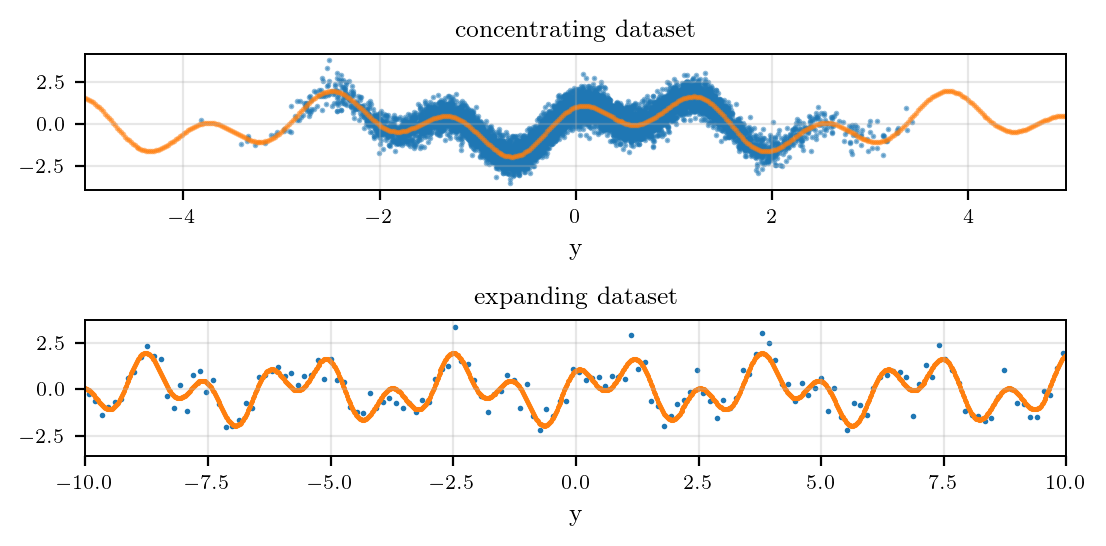

In [4]:


## Generate Data

noise_scale = 0.5
n_data = 10000
n_test = 1000
seed = 3

concentrate_data_train, concentrate_data_test = data.get_concentrating_toy_sin_dataset(
    seed=seed,
    n=n_data,
    noise_scale=noise_scale,
    n_test=n_test,
    x_std = 1.0,
    normalise=False
)



spread_data_train, spread_data_test = data.get_expanding_toy_sin_dataset(
    seed=seed,
    n=n_data,
    noise_scale=noise_scale,
    n_test=n_test,
    n_periods = 15,
    normalise=False
)

fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/2), dpi=200)

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  1, alpha=0.5, c=c[0])
ax[0].scatter(concentrate_data_test.x, concentrate_data_test.y,  1, alpha=0.5, c=c[1])
ax[0].set_xlabel('x')
ax[0].set_xlabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-5,5])
ax[0].set_title('concentrating dataset')

ax[1].scatter(spread_data_train.x, spread_data_train.y,  1, alpha=1, c=c[0])
ax[1].scatter(spread_data_test.x, spread_data_test.y,  0.7, alpha=1, c=c[1])
ax[1].set_xlabel('x')
ax[1].set_xlabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset')

plt.tight_layout()


In [5]:


## hyperparams

concentrate_kernel_config = {
    'signal_scale': jnp.array([2.]),
    'length_scale': jnp.array([0.5]),
}

spread_kernel_config = {
    'signal_scale': jnp.array([2.]),
    'length_scale': jnp.array([0.5]),
}

concentrate_kernel = RBFKernel(kernel_config=concentrate_kernel_config)
spread_kernel = RBFKernel(kernel_config=spread_kernel_config)



In [6]:

## ExactGP fits




concentrate_exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=concentrate_kernel)
concentrate_exact_gp.compute_representer_weights(concentrate_data_train)
concentrate_exact_pred_mean = concentrate_exact_gp.predictive_mean(concentrate_data_train, concentrate_data_test)
concentrate_exact_pred_var = concentrate_exact_gp.predictive_variance(concentrate_data_train, concentrate_data_test) + noise_scale ** 2
concentrate_exact_pred_std = jnp.sqrt(concentrate_exact_pred_var)
print('concentrate_exact_pred_mean', concentrate_exact_pred_mean.shape, 'concentrate_exact_pred_var', concentrate_exact_pred_var.shape)


spread_exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=spread_kernel)
spread_exact_gp.compute_representer_weights(spread_data_train)
spread_exact_pred_mean = spread_exact_gp.predictive_mean(spread_data_train, spread_data_test)
spread_exact_pred_var = spread_exact_gp.predictive_variance(spread_data_train, spread_data_test) + noise_scale ** 2
spread_exact_pred_std = jnp.sqrt(spread_exact_pred_var)
print('spread_exact_pred_mean', spread_exact_pred_mean.shape, 'spread_exact_pred_var', spread_exact_pred_var.shape)



concentrate_exact_pred_mean (1000,) concentrate_exact_pred_var (1000,)
spread_exact_pred_mean (1000,) spread_exact_pred_var (1000,)


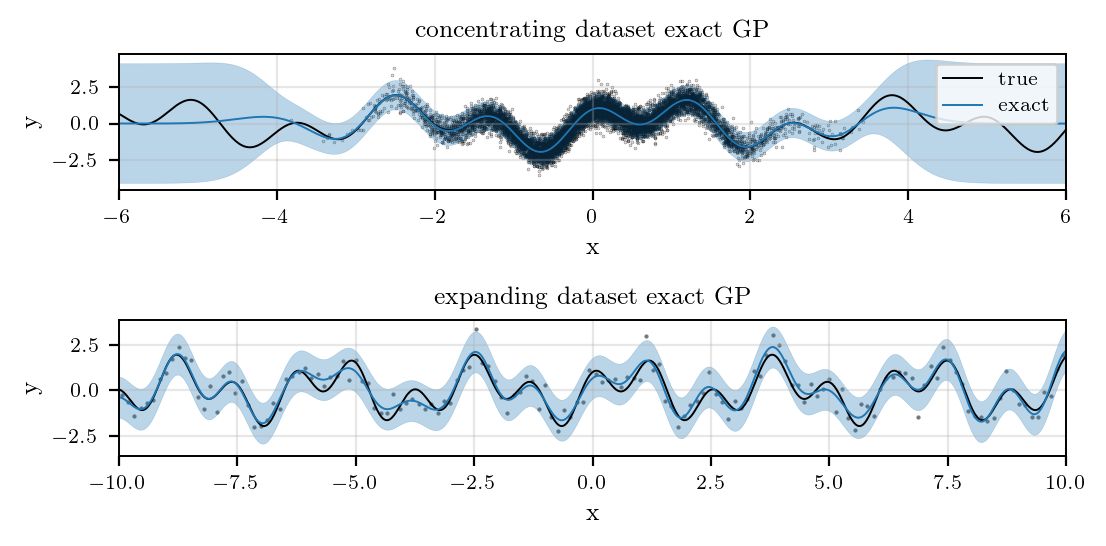

In [7]:


### view exact GP fits

fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/2), dpi=200)

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.05, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6,6])
ax[0].legend()
ax[0].set_title('concentrating dataset exact GP')

ax[1].scatter(spread_data_train.x, spread_data_train.y,  0.3, alpha=0.5, c='k')
ax[1].plot(spread_data_test.x, spread_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(spread_data_test.x.squeeze(), spread_exact_pred_mean, 2*spread_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset exact GP')

plt.tight_layout()

# Sampling fits

In [37]:


from scalable_gps.utils import ExactPredictionsTuple

concentrate_exact_metrics = ExactPredictionsTuple(
                alpha=concentrate_exact_gp.alpha, y_pred_loc=concentrate_exact_pred_mean)

spread_exact_metrics = ExactPredictionsTuple(
                alpha=spread_exact_gp.alpha, y_pred_loc=spread_exact_pred_mean)
            



### SGDGP

In [38]:





def info_to_dict(info, average_samples=True):
    keys = info[0].keys()

    training_results = {}

    for key in keys:
        result_vec = []
        for entry in info:
            if average_samples:
                result_vec.append(entry[key].mean(keepdims=True))
            else:
                result_vec.append(entry[key])
        training_results[key[1:]] = jnp.array(result_vec)
    return training_results

def plot_training_results(info):
    training_results = info_to_dict(info)
    num_entries = len(training_results.keys())
    fig, ax = plt.subplots(1,num_entries, dpi=200, figsize=(text_width,text_width/3))
    for i, key in enumerate(training_results.keys()):
        ax[i].plot(training_results[key])
        ax[i].set_yscale('log')
        ax[i].grid(alpha=0.3)
        ax[i].set_title(key)
    plt.tight_layout()
    plt.show()

### config

### config

In [39]:
config = ml_collections.ConfigDict()
config.train_config = ml_collections.ConfigDict()

config.train_config.iterations = 50000
config.train_config.batch_size = 1000
config.train_config.eval_every = 100

# RFF Configs
config.train_config.n_features_optim = 100
config.train_config.recompute_features = True

# Optimisation Configs
config.train_config.iterative_idx = True
config.train_config.learning_rate = 1e-1
config.train_config.momentum = 0.9
config.train_config.nesterov = True
config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

polyak_k = 50
polyak_step = polyak_k / config.train_config.iterations
print('polyak_step', polyak_step)
config.train_config.polyak = polyak_step

config.train_config.absolute_clipping = 0.1  # -1 to avoid clipping

config.train_config.lr_schedule_name = None # "linear_schedule"
config.train_config.lr_schedule_config = ml_collections.ConfigDict()


# sampling 

config.sampling_config = ml_collections.ConfigDict()

config.sampling_config = config.train_config.copy_and_resolve_references()
config.sampling_config.n_samples = 2000
# Full-batch training configs that get passed
config.sampling_config.iterative_idx = True
config.sampling_config.learning_rate = 2e-5
config.sampling_config.momentum = 0.9
config.sampling_config.iterations = 100000
config.sampling_config.batch_size = 1000
config.sampling_config.absolute_clipping = 0.1  # -1 to avoid clipping


config.sampling_config.eval_every = 100 # eval every how many number of steps 

polyak_k = 50
polyak_step = polyak_k / config.sampling_config.iterations
print('polyak_step', polyak_step)
config.sampling_config.polyak = polyak_step


metrics_list = ['loss',  "test_rmse", "y_pred_diff", "alpha_rkhs_diff"] # see eval_utils.get_eval_fn

# RFF Configs
config.sampling_config.n_features_prior_sample = 2000
config.sampling_config.n_features_optim = 100
config.sampling_config.recompute_features = True
config.sampling_config.loss_objective = 2
# config.sampling_config.use_cholesky_prior_sample = False

config.train_config.preempt_safe=False
config.sampling_config.preempt_safe=False

config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

metrics_list = ["loss",  "test_rmse", "y_pred_diff", "alpha_rkhs_diff"] # "err", "reg",


polyak_step 0.001
polyak_step 0.0005


In [40]:

optim_key = jax.random.PRNGKey(0)


#### concetrate

All save steps: [Array(5000, dtype=int32), Array(10000, dtype=int32), Array(15000, dtype=int32), Array(20000, dtype=int32), Array(25000, dtype=int32), Array(30000, dtype=int32), Array(35000, dtype=int32), Array(40000, dtype=int32), Array(45000, dtype=int32)]


100%|███████████████████████████████████| 50000/50000 [00:40<00:00, 1238.72it/s]


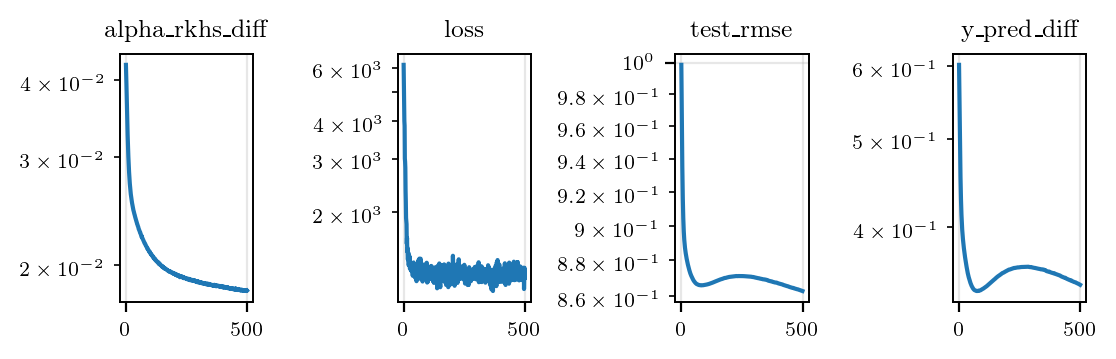

In [41]:
concentrate_sgd_gp = SGDGPModel(noise_scale=noise_scale, kernel=concentrate_kernel)

# MAP
concentrate_alpha_polyak, info = concentrate_sgd_gp.compute_representer_weights(
    key=optim_key,
    train_ds=concentrate_data_train, 
    test_ds=concentrate_data_test,
    config=config.train_config,
    metrics_list=metrics_list,
    exact_metrics=concentrate_exact_metrics  # exact_metrics
)

concentrate_sgd_pred_mean = concentrate_sgd_gp.predictive_mean(concentrate_data_train, concentrate_data_test)
plot_training_results(info)

# sampling

# concentrate_zero_mean_samples, concentrate_alpha_samples, info = concentrate_sgd_gp.compute_posterior_samples(
#                                         optim_key, 
#                                         n_samples=config.sampling_config.n_samples,
#                                         train_ds=concentrate_data_train,
#                                         test_ds=concentrate_data_test,
#                                         config=config.sampling_config,
#                                         use_rff=True,
#                                         n_features=config.sampling_config.n_features_prior_sample,
#                                         metrics_list = metrics_list,
#                                         compare_exact=True,  # allows diff metrics with exact GP
#                                     )
# concentrate_sgd_pred_var_samples = concentrate_sgd_gp.predictive_variance_samples(concentrate_zero_mean_samples) + noise_scale ** 2
# concentrate_sgd_pred_std_samples = jnp.sqrt(concentrate_sgd_pred_var_samples)

# print(f'zero_mean_samples : {concentrate_zero_mean_samples.shape}')
# print(f'alpha_samples : {concentrate_alpha_samples.shape}')

# plot_training_results(info)



In [42]:
config.sampling_config.learning_rate = 3e-4

All save steps: [Array(5000, dtype=int32), Array(10000, dtype=int32), Array(15000, dtype=int32), Array(20000, dtype=int32), Array(25000, dtype=int32), Array(30000, dtype=int32), Array(35000, dtype=int32), Array(40000, dtype=int32), Array(45000, dtype=int32)]


100%|███████████████████████████████████| 50000/50000 [00:39<00:00, 1262.65it/s]


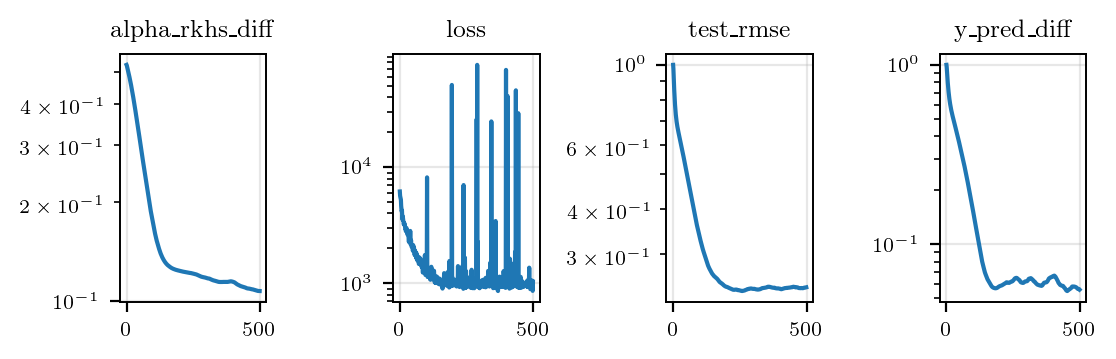

In [43]:
spread_sgd_gp = SGDGPModel(noise_scale=noise_scale, kernel=spread_kernel)

# MAP
spread_alpha_polyak, info = spread_sgd_gp.compute_representer_weights(
    key=optim_key,
    train_ds=spread_data_train, 
    test_ds=spread_data_test,
    config=config.train_config,
    metrics_list=metrics_list,
    exact_metrics=spread_exact_metrics  # exact_metrics
)

spread_sgd_pred_mean = spread_sgd_gp.predictive_mean(spread_data_train, spread_data_test)
plot_training_results(info)

# sampling

# spread_zero_mean_samples, spread_alpha_samples, info = spread_sgd_gp.compute_posterior_samples(
#                                         optim_key, 
#                                         n_samples=config.sampling_config.n_samples,
#                                         train_ds=spread_data_train,
#                                         test_ds=spread_data_test,
#                                         config=config.sampling_config,
#                                         use_rff=True,
#                                         n_features=config.sampling_config.n_features_prior_sample,
#                                         metrics_list = metrics_list,
#                                         compare_exact=True,  # allows diff metrics with exact GP
#                                     )
# spread_sgd_pred_var_samples = spread_sgd_gp.predictive_variance_samples(spread_zero_mean_samples) + noise_scale ** 2
# spread_sgd_pred_std_samples = jnp.sqrt(spread_sgd_pred_var_samples)

# print(f'zero_mean_samples : {spread_zero_mean_samples.shape}')
# print(f'alpha_samples : {spread_alpha_samples.shape}')

# plot_training_results(info)



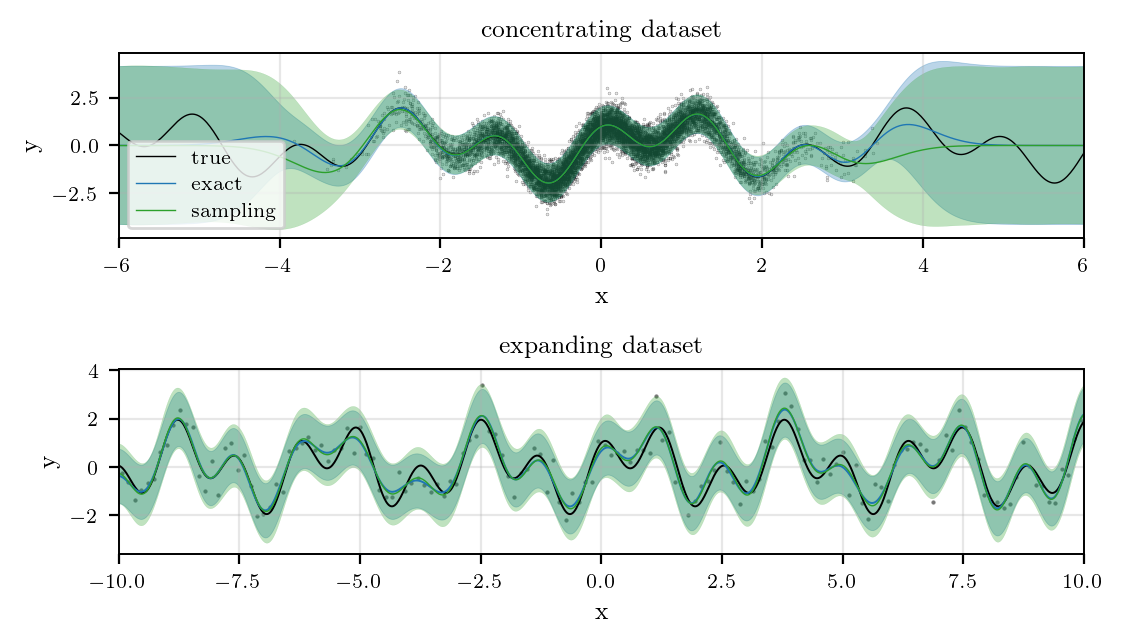

In [45]:
fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/1.7), dpi=200)

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.03, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')


errorfill(concentrate_data_test.x.squeeze(), concentrate_sgd_pred_mean, 2*concentrate_sgd_pred_std_samples,
          color=c[2], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label='sampling')


ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6,6])
ax[0].legend()
ax[0].set_title('concentrating dataset')



ax[1].scatter(spread_data_train.x, spread_data_train.y,  0.3, alpha=0.5, c='k')
ax[1].plot(spread_data_test.x, spread_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(spread_data_test.x.squeeze(), spread_exact_pred_mean, 2*spread_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.7, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')

errorfill(spread_data_test.x.squeeze(), spread_sgd_pred_mean, 2*spread_sgd_pred_std_samples,
          color=c[2], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label=None)


ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset')

plt.tight_layout()

## save sampling alphas 

In [44]:
import pickle
filename = b"./save_data/sampling_outputs.obj"

# save_list = [concentrate_zero_mean_samples, concentrate_alpha_samples,
#              spread_zero_mean_samples, spread_alpha_samples]

# filehandler = open(filename,"wb")
# pickle.dump(save_list,filehandler)
# filehandler.close()

file = open(filename,'rb')
(concentrate_zero_mean_samples, concentrate_alpha_samples,
             spread_zero_mean_samples, spread_alpha_samples) = pickle.load(file) # spread_zero_mean_samples, spread_alpha_samples
file.close()

concentrate_sgd_pred_var_samples = concentrate_sgd_gp.predictive_variance_samples(concentrate_zero_mean_samples) + noise_scale ** 2
concentrate_sgd_pred_std_samples = jnp.sqrt(concentrate_sgd_pred_var_samples)

print(f'zero_mean_samples : {concentrate_zero_mean_samples.shape}')
print(f'alpha_samples : {concentrate_alpha_samples.shape}')

spread_sgd_pred_var_samples = spread_sgd_gp.predictive_variance_samples(spread_zero_mean_samples) + noise_scale ** 2
spread_sgd_pred_std_samples = jnp.sqrt(spread_sgd_pred_var_samples)

print(f'zero_mean_samples : {spread_zero_mean_samples.shape}')
print(f'alpha_samples : {spread_alpha_samples.shape}')


zero_mean_samples : (2000, 1000)
alpha_samples : (2000, 10000)
zero_mean_samples : (2000, 1000)
alpha_samples : (2000, 10000)


# CG inference

In [43]:
SGD_equivalent_batchsize = 33 * 10000 / 50000

print('SGD_equivalent_batchsize', SGD_equivalent_batchsize)


SGD_equivalent_batchsize 6.6


In [54]:
config.cg_config = ml_collections.ConfigDict()
config.cg_config.batch_size = 1
config.cg_config.tol = 1e-2
config.cg_config.maxiter = 34
config.cg_config.atol = 0.0
config.cg_config.eval_every = 1
config.cg_config.preconditioner = False
config.cg_config.pivoted_chol_rank = 100
config.cg_config.pivoted_diag_rtol = 1e-3
config.cg_config.pivoted_jitter = 1.0
config.cg_config.loss_objective = 2
config.cg_config.preempt_safe = False

config.cg_sampling_config = ml_collections.ConfigDict()
config.cg_sampling_config.batch_size = 1
config.cg_sampling_config.n_features_prior_sample = 2000
config.cg_sampling_config.n_samples = 2000
config.cg_sampling_config.tol = 1e-3
config.cg_sampling_config.maxiter = 34
config.cg_sampling_config.atol = 0.0
config.cg_sampling_config.eval_every = 1
config.cg_sampling_config.pivoted_chol_rank = 100
config.cg_sampling_config.pivoted_diag_rtol = 1e-3
config.cg_sampling_config.pivoted_jitter = 1.0
config.cg_sampling_config.loss_objective = 2
config.cg_sampling_config.preconditioner = False


config.sampling_config.n_samples = 2000

In [59]:
del concentrate_cg_gp

In [60]:



concentrate_cg_gp = CGGPModel(noise_scale=noise_scale, kernel=concentrate_kernel)




concentrate_cg_zero_mean_samples, concentrate_cg_alpha_samples, w_samples = concentrate_cg_gp.compute_posterior_samples(
                                        optim_key, 
                                        n_samples=config.sampling_config.n_samples,
                                        train_ds=concentrate_data_train,
                                        test_ds=concentrate_data_test,
                                        config=config.cg_sampling_config,
                                        use_rff=True,
                                        n_features=config.sampling_config.n_features_prior_sample,
                                        metrics_list = [],
                                        compare_exact=False,  # allows diff metrics with exact GP
                                    )

concentrate_cg_gp.compute_representer_weights(
    key = optim_key,
    train_ds=concentrate_data_train, 
    test_ds=concentrate_data_test,
    config=config.cg_config,
    metrics_list=[], # -- if this is None it will run it once -- otherwise it does it every eval_every 
    exact_metrics=concentrate_exact_metrics, # exact_metrics from exact GP 
)

concentrate_cg_pred_mean = concentrate_cg_gp.predictive_mean(concentrate_data_train, concentrate_data_test)

concentrate_cg_pred_var_samples = concentrate_cg_gp.predictive_variance_samples(concentrate_cg_zero_mean_samples[0]) + noise_scale ** 2
concentrate_cg_pred_std_samples = jnp.sqrt(concentrate_cg_pred_var_samples)

print(f'zero_mean_samples : {concentrate_cg_zero_mean_samples.shape}')
print(f'alpha_samples : {concentrate_cg_alpha_samples.shape}')


UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type float32[1,100] wrapped in a DynamicJaxprTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was _fn at /scratch4/ja666/scalable-gaussian-processes/scalable_gps/models/base_gp_model.py:91 traced for jit.
------------------------------
The leaked intermediate value was created on line /scratch4/ja666/scalable-gaussian-processes/scalable_gps/kernels.py:130 (omega_fn). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
/scratch4/ja666/scalable-gaussian-processes/scalable_gps/models/sgd_gp_model.py:82 (compute_representer_weights)
/scratch4/ja666/scalable-gaussian-processes/scalable_gps/models/base_gp_model.py:92 (_fn)
/scratch4/ja666/scalable-gaussian-processes/scalable_gps/kernels.py:83 (feature_fn)
/scratch4/ja666/scalable-gaussian-processes/scalable_gps/kernels.py:108 (feature_params)
/scratch4/ja666/scalable-gaussian-processes/scalable_gps/kernels.py:130 (omega_fn)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

In [64]:
config.cg_config.maxiter = 34
concentrate_cg_gp.compute_representer_weights(
    key = optim_key,
    train_ds=concentrate_data_train, 
    test_ds=concentrate_data_test,
    config=config.cg_config,
    metrics_list=[], # -- if this is None it will run it once -- otherwise it does it every eval_every 
    exact_metrics=concentrate_exact_metrics, # exact_metrics from exact GP 
)

concentrate_cg_pred_mean = concentrate_cg_gp.predictive_mean(concentrate_data_train, concentrate_data_test)


All save steps: [Array(3, dtype=int32), Array(6, dtype=int32), Array(9, dtype=int32), Array(12, dtype=int32), Array(15, dtype=int32), Array(18, dtype=int32), Array(21, dtype=int32), Array(24, dtype=int32), Array(27, dtype=int32), Array(30, dtype=int32), Array(33, dtype=int32)]


100%|███████████████████████████████████████████| 34/34 [00:03<00:00,  9.28it/s]


In [29]:
# from scalable_gps.models import CGGPModel



spread_cg_gp = CGGPModel(noise_scale=noise_scale, kernel=spread_kernel)





spread_cg_zero_mean_samples, spread_cg_alpha_samples, w_samples = spread_cg_gp.compute_posterior_samples(
                                        optim_key, 
                                        n_samples=config.sampling_config.n_samples,
                                        train_ds=spread_data_train,
                                        test_ds=spread_data_test,
                                        config=config.cg_config,
                                        use_rff=True,
                                        n_features=config.sampling_config.n_features_prior_sample,
                                        metrics_list = [],
                                        compare_exact=False,  # allows diff metrics with exact GP
                                    )


spread_cg_pred_var_samples = spread_cg_gp.predictive_variance_samples(spread_cg_zero_mean_samples[0]) + noise_scale ** 2
spread_cg_pred_std_samples = jnp.sqrt(spread_cg_pred_var_samples)

spread_cg_gp.compute_representer_weights(
    key=optim_key,
    train_ds=spread_data_train, 
    test_ds=spread_data_test,
    config=config.cg_config,
    metrics_list=[], # -- if this is None it will run it once -- otherwise it does it every eval_every 
    exact_metrics=spread_exact_metrics, # exact_metrics from exact GP 
)

spread_cg_pred_mean = spread_cg_gp.predictive_mean(spread_data_train, spread_data_test)

print(f'zero_mean_samples : {spread_cg_zero_mean_samples.shape}')
print(f'alpha_samples : {spread_cg_alpha_samples.shape}')


100%|███████████████████████████████████████████| 33/33 [03:43<00:00,  6.78s/it]


alphas: (1, 2000, 10000)
All save steps: [Array(3, dtype=int32), Array(6, dtype=int32), Array(9, dtype=int32), Array(12, dtype=int32), Array(15, dtype=int32), Array(18, dtype=int32), Array(21, dtype=int32), Array(24, dtype=int32), Array(27, dtype=int32), Array(30, dtype=int32)]


100%|███████████████████████████████████████████| 33/33 [00:03<00:00, 10.37it/s]


zero_mean_samples : (1, 2000, 1000)
alpha_samples : (1, 2000, 10000)


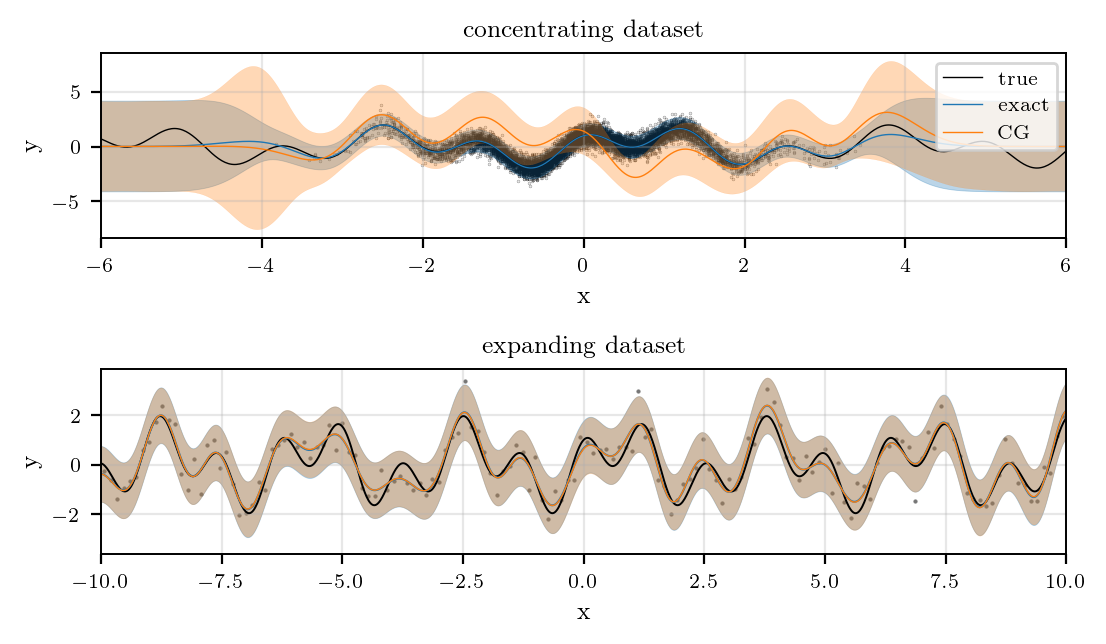

In [65]:
fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/1.7), dpi=200)

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.03, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')


errorfill(concentrate_data_test.x.squeeze(), concentrate_cg_pred_mean, 2*concentrate_cg_pred_std_samples,
          color=c[1], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label='CG')


ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6,6])
ax[0].legend()
ax[0].set_title('concentrating dataset')



ax[1].scatter(spread_data_train.x, spread_data_train.y,  0.3, alpha=0.5, c='k')
ax[1].plot(spread_data_test.x, spread_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(spread_data_test.x.squeeze(), spread_exact_pred_mean, 2*spread_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.7, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')

errorfill(spread_data_test.x.squeeze(), spread_cg_pred_mean, 2*spread_cg_pred_std_samples,
          color=c[1], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label='CG')


ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset')

plt.tight_layout()

## VI

  0%|          | 0/10000 [00:00<?, ?it/s]

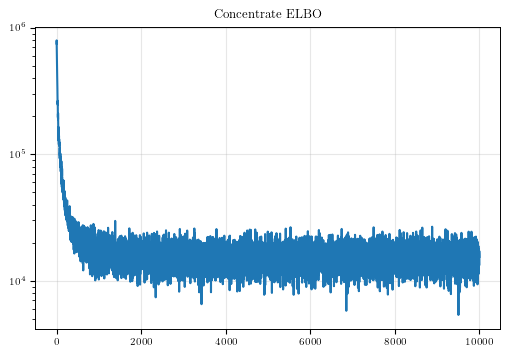

In [31]:
from scalable_gps.SVGP import regression_SVGP
from jax import random
import gpjax as gpx
import optax

# concentrate dataset
num_inducing = 30

key = random.PRNGKey(0)

negative_elbo, init_state, D, get_predictive = regression_SVGP(
    concentrate_data_train, num_inducing=num_inducing, kernel_name = 'RBFKernel', 
    kernel_config=concentrate_kernel_config, ARD=True,
    noise_scale=noise_scale, key=key, inducing_init = "equidistant")

optimizer = optax.adam(learning_rate=0.005)
absolute_clipping = 0.5
optimizer = optax.chain(optax.zero_nans(), optax.clip_by_global_norm(absolute_clipping), optimizer)

num_iters = 10000
batch_size = 100

optimised_state = gpx.fit_batches(
    objective=negative_elbo,
    parameter_state=init_state,
    train_data=D,
    optax_optim=optimizer,
    num_iters=num_iters,
    key=key,
    batch_size=batch_size,
)

concentrate_learned_params, training_history = optimised_state.unpack()
concentrate_function_dist, concentrate_predictive_dist = get_predictive(concentrate_learned_params, concentrate_data_test.x)

plt.figure(dpi=100)
plt.plot(training_history)
plt.yscale('log')
plt.title('Concentrate ELBO')
plt.grid(alpha=0.3)




  0%|          | 0/15000 [00:00<?, ?it/s]

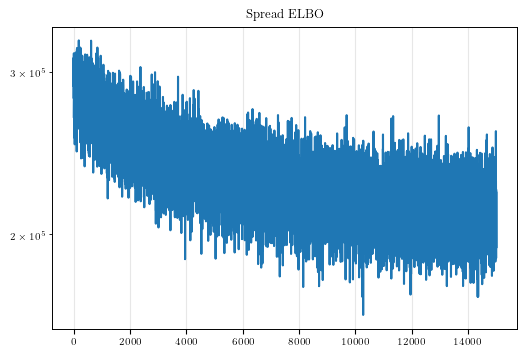

In [32]:
# spread dataset

num_inducing = 800

negative_elbo, init_state, D, get_predictive = regression_SVGP(
    spread_data_train, num_inducing=num_inducing, kernel_name = 'RBFKernel', 
    kernel_config=spread_kernel_config, ARD=True,
    noise_scale=noise_scale, key=key,  inducing_init ="equidistant")

optimizer = optax.adam(learning_rate=0.001)
absolute_clipping = 1.
optimizer = optax.chain(optax.zero_nans(), optax.clip_by_global_norm(absolute_clipping), optimizer)
num_iters = 15000

optimised_state = gpx.fit_batches(
    objective=negative_elbo,
    parameter_state=init_state,
    train_data=D,
    optax_optim=optimizer,
    num_iters=num_iters,
    key=key,
    batch_size=batch_size,
)

spread_learned_params, training_history = optimised_state.unpack()
spread_function_dist, spread_predictive_dist = get_predictive(spread_learned_params, spread_data_test.x)

plt.figure(dpi=100)
plt.plot(training_history)
plt.yscale('log')
plt.title('Spread ELBO')
plt.grid(alpha=0.3)




In [33]:
num_samples = 3


concentrate_VI_mean = concentrate_predictive_dist.mean()
concentrate_VI_std  = concentrate_predictive_dist.stddev()
concentrate_VI_samples = concentrate_function_dist.sample(seed=key, sample_shape=(num_samples, ))


spread_VI_mean = spread_predictive_dist.mean()
spread_VI_std  = spread_predictive_dist.stddev()
spread_VI_samples = spread_function_dist.sample(seed=key, sample_shape=(num_samples, ))



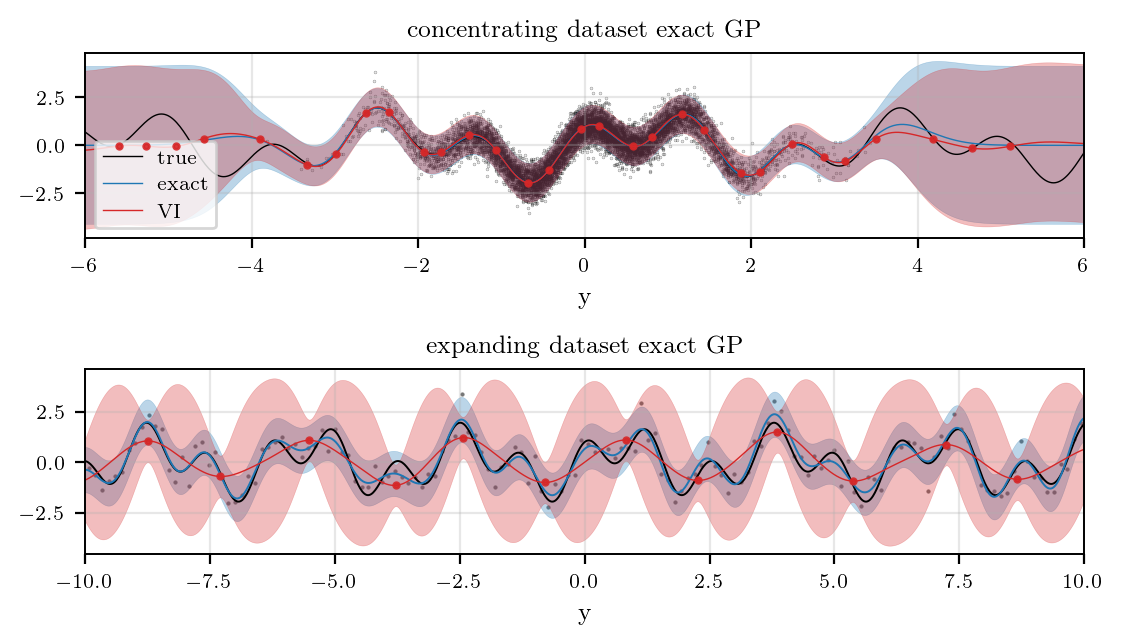

In [34]:
fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/1.7), dpi=200)

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.03, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')


errorfill(concentrate_data_test.x.squeeze(), concentrate_VI_mean, 2*concentrate_VI_std,
          color=c[3], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None)

ax[0].scatter(concentrate_learned_params["variational_family"]["inducing_inputs"],
              concentrate_learned_params["variational_family"]["moments"]["variational_mean"],
             4, c=c[3], alpha=0.9, zorder=10)

# ax[0].plot(concentrate_data_test.x, concentrate_VI_samples.T, alpha=1., c=c[3], linewidth=0.2)

ax[0].set_xlabel('x')
ax[0].set_xlabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6,6])
ax[0].legend()
ax[0].set_title('concentrating dataset exact GP')



ax[1].scatter(spread_data_train.x, spread_data_train.y,  0.3, alpha=0.5, c='k')
ax[1].plot(spread_data_test.x, spread_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(spread_data_test.x.squeeze(), spread_exact_pred_mean, 2*spread_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')

errorfill(spread_data_test.x.squeeze(), spread_VI_mean, 2*spread_VI_std,
          color=c[3], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.5, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None)

ax[1].scatter(spread_learned_params["variational_family"]["inducing_inputs"],
              spread_learned_params["variational_family"]["moments"]["variational_mean"],
             4, c=c[3], alpha=0.9, zorder=10)

# ax[1].plot(spread_data_test.x, spread_VI_samples.T, alpha=1., c=c[3], linewidth=0.2)

ax[1].set_xlabel('x')
ax[1].set_xlabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset exact GP')

plt.tight_layout()


# Plot comparing approximate inference methods

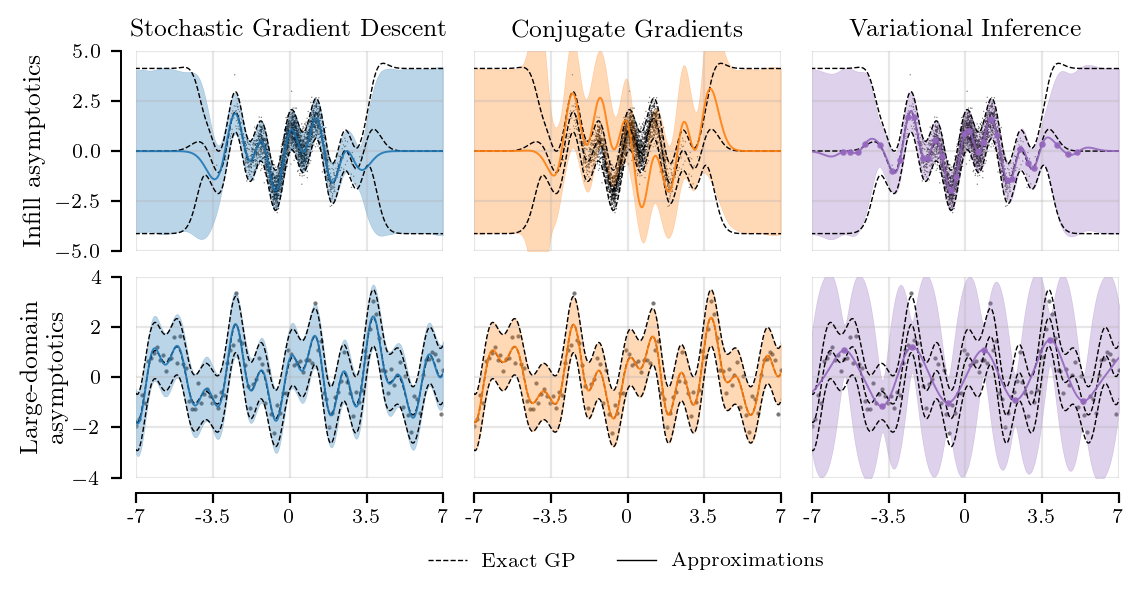

In [78]:
fig, ax = plt.subplots(2,3, figsize=(text_width, text_width/2), sharey='row', sharex=True, dpi=200)

###### CONFIGS

titlepad = 5

# samples

top_subsample_rate = 3
top_point_size = 0.25
top_point_alpha = 0.5

# exact GP
exact_errorbar_lw = 0.5
exact_mean_lw = 0.5
exact_alpha = 1

# methods
method_lw = 0.7
fill_alpha = 0.3
fill_linewidths = 0.2
line_alpha = 0.9

# VI inducing 

VI_inducing_size = 1.8
VI_inducing_alpha = 0.9

#############

# sampling

## concentrating

ax[0,0].scatter(concentrate_data_train.x[::top_subsample_rate],
                concentrate_data_train.y[::top_subsample_rate],  top_point_size,
                alpha=top_point_alpha, c='k', linewidths=None, edgecolors='none')

ax[0,0].plot(concentrate_data_test.x, concentrate_exact_pred_mean,
             alpha=exact_alpha, c='k', linewidth=exact_mean_lw, label='Exact GP', linestyle='--')
ax[0,0].plot(concentrate_data_test.x, concentrate_exact_pred_mean+2*concentrate_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')
ax[0,0].plot(concentrate_data_test.x, concentrate_exact_pred_mean-2*concentrate_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')




errorfill(concentrate_data_test.x.squeeze(), concentrate_sgd_pred_mean, 2*concentrate_sgd_pred_std_samples,
          color=c[0], alpha_fill=fill_alpha, line_alpha=line_alpha, ax=ax[0,0],
              lw=method_lw, linestyle='-', fill_linewidths=fill_linewidths, marker=None,
          markersize=1, label='SGD')


# ax[0,0].set_xlabel('x')
# ax[0,0].set_ylabel('y')
ax[0,0].grid(alpha=0.3)
ax[0,0].set_xlim([-6,6])
# ax[0].legend()
ax[0,0].set_title('Stochastic Gradient Descent', pad=titlepad)

## Spread


ax[1,0].scatter(spread_data_train.x, spread_data_train.y,  0.3, alpha=0.5, c='k')

ax[1,0].plot(spread_data_test.x, spread_exact_pred_mean,
             alpha=exact_alpha, c='k', linewidth=exact_mean_lw, label='Exact GP', linestyle='--')
ax[1,0].plot(spread_data_test.x, spread_exact_pred_mean+2*spread_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')
ax[1,0].plot(spread_data_test.x, spread_exact_pred_mean-2*spread_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')

# ax[1,0].plot(spread_data_test.x, spread_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

# errorfill(spread_data_test.x.squeeze(), spread_exact_pred_mean, 2*spread_exact_pred_std,
#           color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1,0],
#               lw=0.7, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')


errorfill(spread_data_test.x.squeeze(), spread_sgd_pred_mean, 2*spread_sgd_pred_std_samples,
          color=c[0], alpha_fill=fill_alpha, line_alpha=line_alpha, ax=ax[1,0],
              lw=method_lw, linestyle='-', fill_linewidths=fill_linewidths, marker=None,
          markersize=1, label='SGD')

# ax[1,0].set_xlabel('x')
# ax[1].set_ylabel('y')
ax[1,0].grid(alpha=0.3)
ax[1,0].set_xlim([-8,8])
# ax[1].set_title('expanding dataset')



########################################
# CG

## concentrating

ax[0,1].scatter(concentrate_data_train.x[::top_subsample_rate],
                concentrate_data_train.y[::top_subsample_rate],  top_point_size,
                alpha=top_point_alpha, c='k', edgecolors='none')


ax[0,1].plot(concentrate_data_test.x, concentrate_exact_pred_mean,
             alpha=exact_alpha, c='k', linewidth=exact_mean_lw, label='Exact GP', linestyle='--')

ax[0,1].plot(concentrate_data_test.x, concentrate_exact_pred_mean+2*concentrate_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')
ax[0,1].plot(concentrate_data_test.x, concentrate_exact_pred_mean-2*concentrate_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')

# ax[0,1].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

# errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
#           color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0,1],
#               lw=0.7, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')



errorfill(concentrate_data_test.x.squeeze(), concentrate_cg_pred_mean, 2*concentrate_cg_pred_std_samples,
          color=c[1], alpha_fill=fill_alpha, line_alpha=line_alpha, ax=ax[0,1],
              lw=method_lw, linestyle='-', fill_linewidths=fill_linewidths, marker=None,
          markersize=1, label='CG')


# ax[0].set_xlabel('x')
# ax[0].set_ylabel('y')
ax[0,1].grid(alpha=0.3)
ax[0,1].set_xlim([-6,6])
# ax[0,1].legend()
ax[0,1].set_title('Conjugate Gradients',  pad=titlepad)


## Spread


ax[1,1].scatter(spread_data_train.x, spread_data_train.y,  0.3, alpha=0.5, c='k')
# ax[1,1].plot(spread_data_test.x, spread_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')


ax[1,1].plot(spread_data_test.x, spread_exact_pred_mean,
             alpha=exact_alpha, c='k', linewidth=exact_mean_lw, label='Exact GP', linestyle='--')
ax[1,1].plot(spread_data_test.x, spread_exact_pred_mean+2*spread_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')
ax[1,1].plot(spread_data_test.x, spread_exact_pred_mean-2*spread_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')

# errorfill(spread_data_test.x.squeeze(), spread_exact_pred_mean, 2*spread_exact_pred_std,
#           color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1,1],
#               lw=0.7, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')


errorfill(spread_data_test.x.squeeze(), spread_cg_pred_mean, 2*spread_cg_pred_std_samples,
          color=c[1], alpha_fill=fill_alpha, line_alpha=line_alpha, ax=ax[1,1],
              lw=method_lw, linestyle='-', fill_linewidths=fill_linewidths, marker=None,
          markersize=1, label='CG')


# ax[1,1].set_xlabel('x')
# ax[1].set_ylabel('y')
ax[1,1].grid(alpha=0.3)
ax[1,1].set_xlim([-8,8])
# ax[1].set_title('expanding dataset')


############################################
# VI

## concentrating

ax[0,2].scatter(concentrate_data_train.x[::top_subsample_rate],
                concentrate_data_train.y[::top_subsample_rate],  top_point_size,
                alpha=top_point_alpha, c='k', edgecolors='none')


ax[0,2].plot(concentrate_data_test.x, concentrate_exact_pred_mean,
             alpha=exact_alpha, c='k', linewidth=exact_mean_lw, label='Exact GP', linestyle='--')

ax[0,2].plot(concentrate_data_test.x, concentrate_exact_pred_mean+2*concentrate_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')
ax[0,2].plot(concentrate_data_test.x, concentrate_exact_pred_mean-2*concentrate_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')


# ax[0,2].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

# errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
#           color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0,2],
#               lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')


errorfill(concentrate_data_test.x.squeeze(), concentrate_VI_mean, 2*concentrate_VI_std,
          color='tab:purple', alpha_fill=fill_alpha, line_alpha=line_alpha, ax=ax[0,2],
              lw=method_lw, linestyle='-', fill_linewidths=fill_linewidths, marker=None,
          markersize=1)

ax[0,2].scatter(concentrate_learned_params["variational_family"]["inducing_inputs"],
              concentrate_learned_params["variational_family"]["moments"]["variational_mean"],
             VI_inducing_size, c='tab:purple', alpha=VI_inducing_alpha, zorder=10)



# ax[0].plot(concentrate_data_test.x, concentrate_VI_samples.T, alpha=1., c=c[3], linewidth=0.2)

# ax[0].set_xlabel('x')
# ax[0].set_xlabel('y')
ax[0,2].grid(alpha=0.3)

# ax[0,2].legend()
ax[0,2].set_title('Variational Inference', pad=titlepad)


## Spread

ax[1,2].scatter(spread_data_train.x, spread_data_train.y,  0.3, alpha=0.5, c='k')
# ax[1,2].plot(spread_data_test.x, spread_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

ax[1,2].plot(spread_data_test.x, spread_exact_pred_mean,
             alpha=exact_alpha, c='k', linewidth=exact_mean_lw, label='Exact GP', linestyle='--')
ax[1,2].plot(spread_data_test.x, spread_exact_pred_mean+2*spread_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')
ax[1,2].plot(spread_data_test.x, spread_exact_pred_mean-2*spread_exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')

# errorfill(spread_data_test.x.squeeze(), spread_exact_pred_mean, 2*spread_exact_pred_std,
#           color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1,2],
#               lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')

# errorfill(spread_data_test.x.squeeze(), spread_VI_mean, 2*spread_VI_std,
#           color=c[3], alpha_fill=0.15, line_alpha=1, ax=ax[1,2],
#               lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='VI')

errorfill(spread_data_test.x.squeeze(), spread_VI_mean, 2*spread_VI_std,
          color='tab:purple', alpha_fill=fill_alpha, line_alpha=line_alpha, ax=ax[1,2],
          lw=method_lw, linestyle='-', fill_linewidths=fill_linewidths, marker=None,
          markersize=1, label=None)

ax[1,2].scatter(spread_learned_params["variational_family"]["inducing_inputs"],
              spread_learned_params["variational_family"]["moments"]["variational_mean"],
             VI_inducing_size, c='tab:purple', alpha=VI_inducing_alpha, zorder=10)



# ax[1].plot(spread_data_test.x, spread_VI_samples.T, alpha=1., c=c[3], linewidth=0.2)

# ax[1,2].set_xlabel('x')
# ax[1].set_xlabel('y')
ax[1,2].grid(alpha=0.3)

# ax[1].set_title('expanding dataset exact GP')

################################################


ax[0,0].set_xlim([-7,7])
ax[1,0].set_xlim([-7,7])

ax[0,0].set_ylim([-5.,5.])
ax[0,0].set_yticks([-5., -2.5, 0 , 2.5, 5.])
ax[1,0].set_ylim([-4,4])
ax[1,0].set_xticks([-7., -3.5, 0 , 3.5, 7.], labels=[-7, -3.5, 0 , 3.5, 7])

for aax in ax.ravel():
    aax.spines[['right', 'top']].set_visible(False)
    aax.spines['bottom'].set_position(('axes', -0.075))
    aax.spines['left'].set_position(('axes', -0.05))
    aax.tick_params(axis='x', which='major', pad=2.5)
    
for aax in ax[0]:
    aax.spines[['bottom']].set_visible(False)
    
    for tick in aax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        
for i_col in range(1, ax.shape[1]):
    for i_row in range(ax.shape[0]):
        ax[i_row,i_col].spines[['left']].set_visible(False)
        
        for tick in ax[i_row,i_col].yaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
        

plt.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.13)

ax[0,0].set_ylabel('Infill asymptotics')
ax[1,0].set_ylabel('Large-domain\n asymptotics', labelpad=2)

ax[1,2].plot([-10,-9], [-10,-9], alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, 
             linestyle='-', label='Approximations')

ax[1,2].legend(frameon=False, ncols=3, loc='lower right', bbox_to_anchor=(0.1, -0.55))

# plt.savefig('./plots' + f'/toy_comparison_new_colors.pdf', dpi=350, format="pdf", bbox_inches='tight', pad_inches=0.01)

